![Eigenfaces](eigenfaces.png)

# Caracteristiques Propres

Objectifs :

- Apprendre à extraire des caractéristiques plus abstraites sur des images de façon semi-automatique
- Mélanger les approches d'entrainement non-supervisé et supervisé

## Partie 1 : recherche d'information

- Qu'est-ce que la méthode _Eigenface_ en vision par ordinateur ?  
```md
C'est une méthode qui utilise l'analyse en composantes principales pour extraire des features d'un visage = PCA en fait

Calcul d'une image moyenne, puis on retire à chaque image l'image moyenne --> Différences entre les visages en termes de colorimétrie et de luminance
```
- Quelles sont les applications concrètes de cette méthode ?  
```md
Reconnaissance faciale
```
- Quel algorithme non-supervisé est utilisé par cette méthode ?  
```md
APC (ou PCA) : combine variables corrélées pour réduire les dimensions
```
- Que signifie le terme _eigen_ ?  
```md
Propre : peut-être car méthode basée sur vecteurs propres = décrire une matrice pour en générer d'autres 
```

## Partie 2 : reconnaissance de visages

Nous allons mettre en pratique la méthode de _Eigenface_ (ou _visage propre_) pour reproduire son utilisation historique :
la reconnaissance de visages. Cette problématique rentre dans la catégorie de classification multi-classe.

Un jeu de données iconique pour cette application est le ["Labeled Faces in the Wild" ("LFW")](http://vis-www.cs.umass.edu/lfw/).

La bibliothèque Scikit-Learn permet d'utiliser le
[jeu de données](https://scikit-learn.org/stable/datasets/real_world.html#labeled-faces-in-the-wild-dataset)
directement.

Etapes :

1. Extraire le jeu de données LFW (utiliser `min_faces_per_person=70` pour réduire le nombre de classes)
2. Effectuer une analyse de données exploratoire
3. Afficher un exemple d'image de chaque classe
4. Normaliser les features du jeu de données
5. Entrainer et évaluer un classifieur de régression logistique sur les images brutes
6. Entrainer et pré-traiter les images avec la méthode _Eigenface_
7. Afficher les 10 premiers masques _Eigenfaces_ signifiants : extraire _components = masque (coefficients utilisés pour faire la pca)
8. Entrainer et évaluer un classifieur de régression logistique sur les _Eigenfaces_
9. Afficher 10 images bien classifiées et 10 images mal classifiées
10. Conclure

### Extraction jeu de données

In [1]:
from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(min_faces_per_person=70)

for name in lfw_people.target_names:
    print(name)

Ariel Sharon
Colin Powell
Donald Rumsfeld
George W Bush
Gerhard Schroeder
Hugo Chavez
Tony Blair


In [2]:
type(lfw_people)

sklearn.utils.Bunch

### Analyse exploratoire

Shape du jeu de données

In [4]:
lfw_people.data.shape

(1288, 2914)

In [31]:
type(lfw_people.data)

numpy.ndarray

In [6]:
lfw_people.data

array([[254.33333 , 254.33333 , 253.66667 , ...,  87.666664,  88.333336,
         86.333336],
       [ 38.      ,  43.333332,  53.      , ..., 115.333336, 117.      ,
        143.66667 ],
       [ 88.333336,  92.666664, 113.      , ..., 182.33333 , 183.66667 ,
        182.66667 ],
       ...,
       [ 86.333336,  83.333336,  76.333336, ...,  48.      ,  48.666668,
         41.      ],
       [ 49.      ,  55.333332,  76.333336, ..., 186.      , 176.      ,
        160.66667 ],
       [ 31.      ,  26.333334,  28.333334, ...,  34.      ,  42.      ,
         69.666664]], dtype=float32)

In [15]:
len(lfw_people.target)

1288

Conversion en dataframe

In [29]:
import pandas as pd

df = pd.DataFrame(data = lfw_people.data)
df['label'] = lfw_people.target
df

,0,1,2,3,4,5,6,7,8,9,...,2905,2906,2907,2908,2909,2910,2911,2912,2913,label
0,254.333328,254.333328,253.666672,250.666672,242.333328,202.000000,151.000000,146.333328,182.000000,197.333328,...,96.000000,93.666664,91.333336,90.333336,89.333336,87.333336,87.666664,88.333336,86.333336,5
1,38.000000,43.333332,53.000000,41.000000,50.666668,88.666664,113.666664,125.333336,142.000000,155.666672,...,78.333336,80.666664,88.666664,109.666664,123.333336,118.000000,115.333336,117.000000,143.666672,6
2,88.333336,92.666664,113.000000,129.000000,140.666672,150.333328,155.333328,157.000000,155.333328,159.666672,...,101.333336,118.666664,126.666664,111.666664,123.333336,172.666672,182.333328,183.666672,182.666672,3
3,13.000000,7.000000,6.000000,7.333333,5.000000,11.000000,28.000000,107.333336,179.000000,172.666672,...,238.000000,240.333328,239.000000,231.333328,142.000000,32.666668,28.000000,45.000000,51.666668,1
4,123.333336,121.000000,123.000000,128.666672,130.333328,129.666672,131.666672,137.333328,142.333328,142.000000,...,4.333333,5.000000,6.000000,11.000000,9.333333,13.666667,44.000000,72.000000,70.333336,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,16.666666,24.333334,54.666668,89.000000,97.333336,102.666664,103.333336,103.666664,111.000000,121.666664,...,135.000000,177.666672,231.000000,244.000000,204.333328,90.666664,48.000000,52.666668,58.333332,4
1284,45.666668,47.666668,47.000000,59.000000,81.666664,114.000000,147.666672,168.666672,176.000000,179.666672,...,96.000000,91.666664,93.666664,95.333336,92.000000,88.333336,88.666664,95.666664,117.000000,5
1285,86.333336,83.333336,76.333336,74.666664,88.000000,114.333336,145.000000,167.333328,180.666672,183.666672,...,50.666668,46.666668,42.666668,40.666668,41.333332,44.000000,48.000000,48.666668,41.000000,5
1286,49.000000,55.333332,76.333336,89.666664,77.000000,75.333336,98.666664,118.666664,110.666664,81.666664,...,169.333328,170.666672,174.333328,184.333328,202.000000,201.000000,186.000000,176.000000,160.666672,3


Répartition des classes

<AxesSubplot:ylabel='Count'>

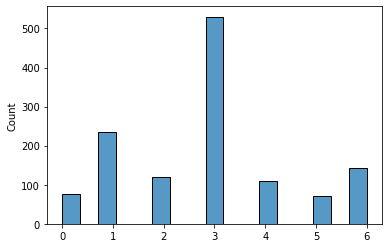

In [12]:
import seaborn as sns

sns.histplot(x=lfw_people.target)

Affichage une image par classe

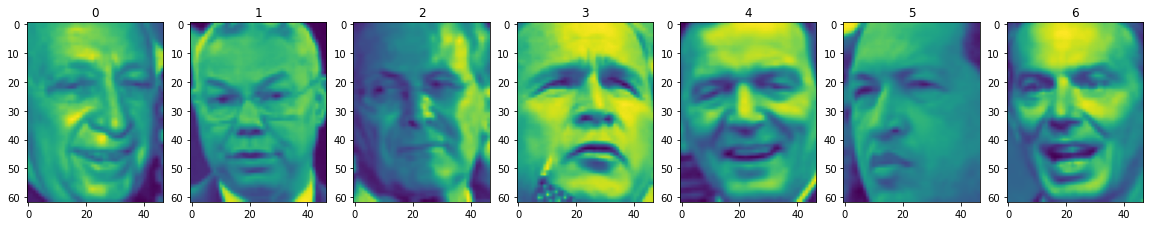

In [62]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(20,15))

'''
ArielSharon = df[df['label'] == 0][0]
ColinPowell = df[df['label'] == 1][0]
DonaldRumsfeld = df[df['label'] == 2][0]
GeorgeWBush = df[df['label'] == 3][0]
GerhardSchroeder = df[df['label'] == 4][0]
HugoChavez = df[df['label'] == 5][0]
TonyBlair = df[df['label'] == 6][0]
'''
images = []

for i in range(7):
    images.append(np.reshape(lfw_people.data[np.where(lfw_people.target == i)[0]][0],(62,47)))


for i in range(1,8):
    fig.add_subplot(1,7,i)
    plt.imshow(images[i - 1])
    plt.title(i-1)

### Régression logistique données brutes

Split données

In [65]:
from sklearn.model_selection import train_test_split

X = lfw_people.data
y = lfw_people.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)


Répartition des classes jeu d'entraînement

<AxesSubplot:ylabel='Count'>

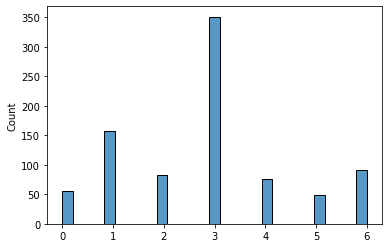

In [67]:
sns.histplot(x=y_train)

Proportion de la classe la moins bien représentée

In [69]:
sum(y_train == 5) / len(y_train) * 100

5.56844547563805

Il faudrait sous-échantillonner pour ré-équilibrer un peu les classes, mais voyons ce que cela donne sans ré-équilibrage.

Pipeline

In [70]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

pipeline_brut = Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression())])

pipeline_brut.fit(X_train, y_train)

/home/marouan/.local/share/virtualenvs/bases-sur-les-images-FaXbB9Ky/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression())])

Prédiction

In [71]:
pred_brut = pipeline_brut.predict(X_test)
pred_brut

array([3, 3, 6, 3, 3, 3, 4, 1, 3, 3, 3, 3, 3, 6, 3, 3, 3, 1, 3, 4, 1, 6,
       3, 0, 0, 1, 0, 3, 3, 3, 2, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 1,
       1, 1, 4, 3, 4, 3, 3, 3, 0, 3, 6, 2, 1, 3, 5, 3, 1, 1, 0, 4, 2, 4,
       6, 4, 1, 3, 6, 6, 3, 3, 3, 2, 1, 6, 4, 4, 4, 0, 4, 3, 3, 3, 3, 3,
       3, 3, 3, 6, 3, 1, 1, 6, 1, 1, 6, 6, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1,
       4, 1, 3, 4, 3, 1, 3, 4, 1, 3, 1, 3, 3, 0, 3, 4, 4, 3, 1, 3, 6, 6,
       6, 3, 4, 4, 3, 3, 1, 1, 2, 2, 5, 1, 3, 5, 1, 3, 6, 1, 1, 1, 1, 3,
       3, 3, 6, 1, 1, 1, 6, 5, 5, 1, 3, 1, 5, 1, 2, 3, 1, 1, 6, 1, 5, 1,
       3, 2, 2, 4, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 6, 3, 3, 6,
       3, 6, 3, 2, 1, 2, 3, 1, 6, 2, 2, 2, 6, 5, 3, 3, 3, 3, 3, 2, 0, 1,
       2, 3, 1, 1, 6, 3, 3, 3, 1, 3, 3, 3, 1, 0, 3, 1, 6, 3, 3, 3, 3, 4,
       2, 3, 3, 0, 3, 3, 3, 4, 4, 3, 3, 4, 3, 4, 2, 1, 6, 0, 3, 3, 6, 1,
       3, 6, 1, 1, 3, 6, 1, 1, 3, 3, 6, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1,
       3, 3, 3, 4, 4, 3, 5, 3, 2, 1, 4, 5, 3, 6, 3,

Matrice de confusion

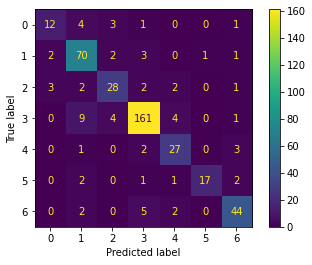

In [72]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_brut = confusion_matrix(y_test, pred_brut)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_brut)
disp.plot()

plt.show()

Métriques

In [73]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred_brut))

              precision    recall  f1-score   support

           0       0.71      0.57      0.63        21
           1       0.78      0.89      0.83        79
           2       0.76      0.74      0.75        38
           3       0.92      0.90      0.91       179
           4       0.75      0.82      0.78        33
           5       0.94      0.74      0.83        23
           6       0.83      0.83      0.83        53

    accuracy                           0.84       426
   macro avg       0.81      0.78      0.79       426
weighted avg       0.85      0.84      0.84       426



### Régression logistique Eigenface

Pipeline

In [96]:
from sklearn.decomposition import PCA

pipeline_pca = Pipeline([('scaler', StandardScaler()),('pca', PCA(n_components=300)), ('classifier', LogisticRegression())])

pipeline_pca.fit(X_train, y_train)

/home/marouan/.local/share/virtualenvs/bases-sur-les-images-FaXbB9Ky/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=300)),
                ('classifier', LogisticRegression())])

Prédiction

In [97]:
pred_pca = pipeline_pca.predict(X_test)
pred_pca

array([3, 3, 6, 3, 3, 3, 5, 1, 3, 3, 3, 3, 3, 6, 3, 3, 3, 1, 3, 4, 1, 6,
       3, 0, 0, 1, 0, 3, 3, 3, 2, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 1,
       1, 1, 4, 3, 4, 3, 3, 3, 0, 3, 6, 2, 1, 3, 5, 3, 1, 1, 0, 4, 2, 4,
       6, 4, 1, 3, 6, 6, 3, 3, 3, 2, 1, 6, 4, 4, 4, 0, 4, 3, 3, 3, 3, 3,
       3, 3, 3, 6, 3, 1, 1, 6, 1, 1, 6, 6, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1,
       4, 1, 3, 3, 3, 1, 3, 4, 1, 3, 1, 3, 3, 0, 3, 4, 4, 3, 1, 3, 6, 6,
       6, 3, 4, 4, 4, 3, 1, 6, 2, 2, 5, 1, 3, 5, 1, 3, 6, 1, 1, 1, 1, 3,
       3, 3, 6, 1, 1, 1, 6, 5, 5, 1, 3, 1, 5, 1, 2, 3, 1, 1, 6, 3, 5, 1,
       3, 2, 2, 4, 3, 3, 3, 1, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 6, 3, 3, 6,
       3, 6, 5, 2, 1, 2, 3, 1, 6, 2, 2, 2, 4, 5, 3, 3, 3, 3, 3, 2, 0, 1,
       2, 3, 1, 1, 6, 3, 3, 3, 1, 3, 3, 3, 1, 0, 3, 1, 6, 3, 3, 3, 3, 4,
       2, 3, 3, 0, 3, 3, 3, 4, 4, 3, 2, 4, 3, 4, 1, 1, 6, 0, 3, 3, 2, 1,
       3, 6, 1, 1, 3, 6, 1, 1, 3, 3, 6, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1,
       3, 3, 3, 4, 4, 3, 5, 3, 2, 1, 4, 5, 3, 6, 3,

Matrice de confusion

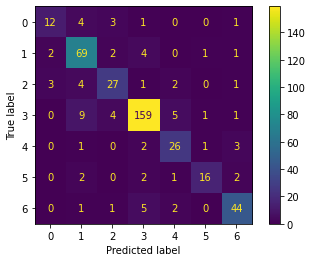

In [98]:
cm_pca = confusion_matrix(y_test, pred_pca)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_pca)
disp.plot()

plt.show()

Métriques

In [99]:
print(classification_report(y_test, pred_pca))

              precision    recall  f1-score   support

           0       0.71      0.57      0.63        21
           1       0.77      0.87      0.82        79
           2       0.73      0.71      0.72        38
           3       0.91      0.89      0.90       179
           4       0.72      0.79      0.75        33
           5       0.84      0.70      0.76        23
           6       0.83      0.83      0.83        53

    accuracy                           0.83       426
   macro avg       0.79      0.77      0.77       426
weighted avg       0.83      0.83      0.83       426



### Affichage masques et images

10 premiers masques signifiants

In [83]:
components = pipeline_pca['pca'].components_
components.shape

(100, 2914)

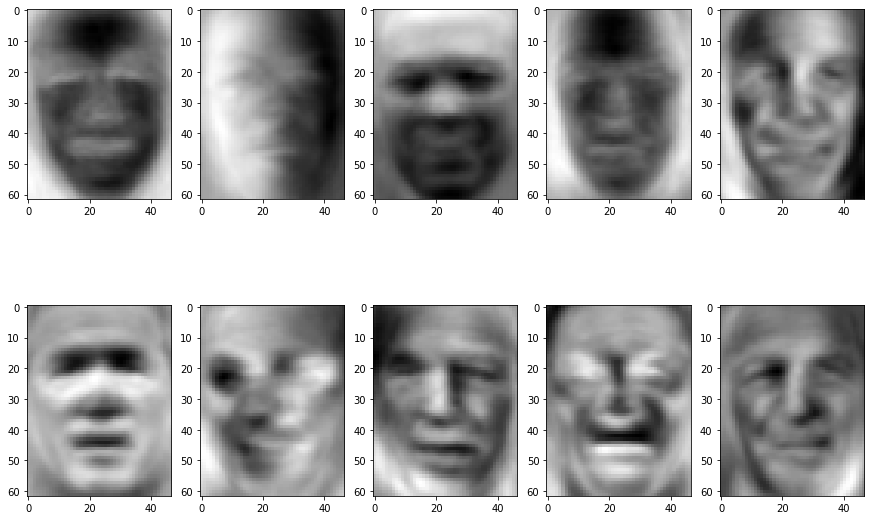

In [91]:
fig = plt.figure(figsize=(15,10))

for i in range(0,10):
    fig.add_subplot(2,5,i+1)
    plt.imshow(np.reshape(components[:11,:][i], newshape=(62,47)), cmap='gray')

10 images bien classifiées

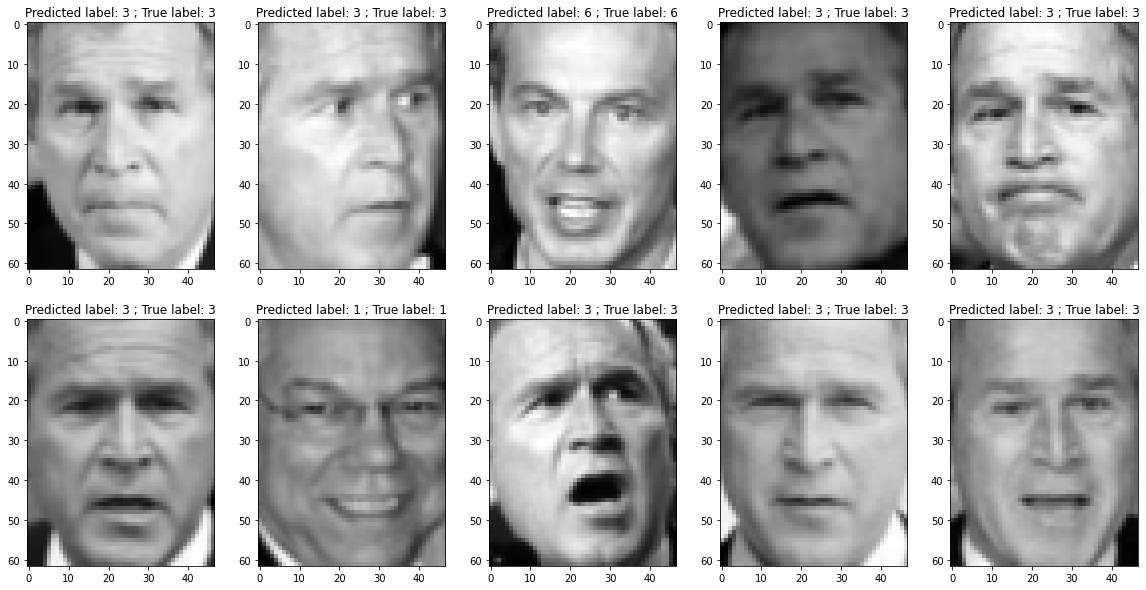

In [122]:
fig = plt.figure(figsize=(20,10))



for i in range(0,10):
    fig.add_subplot(2,5,i+1)
    plt.imshow(np.reshape(X_test[np.where(pred_pca == y_test)][i], newshape=(62,47)), cmap='gray')
    plt.title(f"Predicted label: {pred_pca[np.where(pred_pca == y_test)[0][i]]} ; True label: {y_test[np.where(pred_pca == y_test)[0][i]]}")

10 images mal classifiées

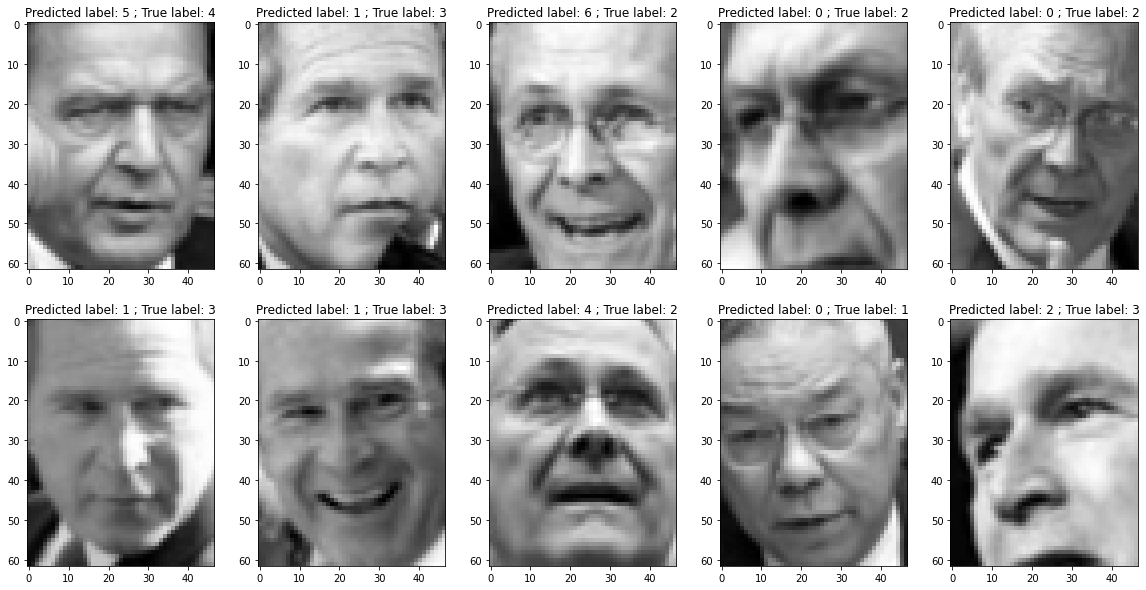

In [116]:
fig = plt.figure(figsize=(20,10))



for i in range(0,10):
    fig.add_subplot(2,5,i+1)
    plt.imshow(np.reshape(X_test[np.where(pred_pca != y_test)][i], newshape=(62,47)), cmap='gray')
    plt.title(f"Predicted label: {pred_pca[np.where(pred_pca != y_test)[0][i]]} ; True label: {y_test[np.where(pred_pca != y_test)[0][i]]}")

### Conclusion

1ère approche pour la reconnaissance de visage plutôt satisfaisante : environ 80% accuracy
Intérêt de la PCA pour réduire la dimension : 200 composants = même accuracy qu'avec données brutes, avec moins de dimensions donc moins de temps de calcul
Attention sur-échantillonnage peut biaiser l'algorithme

## Partie 3 : reconnaissance de caractères

- Appliquer la même méthodologie _Eigenfaces_ qu'à la partie 2 avec le jeu de données MNIST
- Evaluer la performance de classification par rapport aux méthodes d'ingénierie des caractéristiques manuelles effectuées précédemment

In [123]:
df_train = pd.read_csv('mnist_train.csv')
df_test = pd.read_csv('mnist_test.csv')

In [126]:
X_train_mnist = df_train.drop(columns='label')
y_train_mnist = df_train['label']

X_test_mnist = df_test.drop(columns='label')
y_test_mnist = df_test['label']

In [135]:
pipeline_mnist = Pipeline([('scaler', StandardScaler()),('pca', PCA(n_components=10)), ('classifier', LogisticRegression())])

pipeline_mnist.fit(X_train_mnist, y_train_mnist)

/home/marouan/.local/share/virtualenvs/bases-sur-les-images-FaXbB9Ky/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=10)),
                ('classifier', LogisticRegression())])

In [136]:
pred_mnist = pipeline_mnist.predict(X_test_mnist)

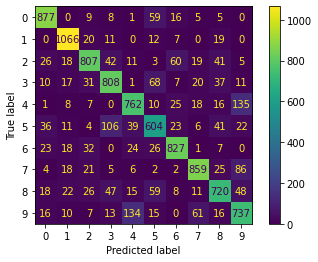

In [137]:
cm_mnist = confusion_matrix(y_test_mnist, pred_mnist)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mnist)
disp.plot()

plt.show()

In [138]:
print(classification_report(y_test_mnist, pred_mnist))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       980
           1       0.90      0.94      0.92      1135
           2       0.84      0.78      0.81      1032
           3       0.78      0.80      0.79      1010
           4       0.77      0.78      0.77       982
           5       0.70      0.68      0.69       892
           6       0.85      0.86      0.86       958
           7       0.86      0.84      0.85      1028
           8       0.78      0.74      0.76       974
           9       0.71      0.73      0.72      1009

    accuracy                           0.81     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.81      0.81      0.81     10000



Meilleurs résultats avec la PCA que les features crées à partir de la somme des pixels dans l'activité précédente